## Work
1. 試比較有 BN 在 Batch_size = 2, 16, 32, 128, 256 下的差異
2. 請嘗試將 BN 放在 Activation 之前，並比較訓練結果
3. 請於 BN 放在 Input Layer 後，並比較結果

In [1]:
import os
import keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 2s 0us/step


In [0]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [0]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [0]:
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = keras.layers.BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = keras.layers.BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [0]:
def build_mlp_2(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
        else:
            x = keras.layers.BatchNormalization()(x)
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [0]:
def build_mlp_2_1(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    x = keras.layers.BatchNormalization()(input_layer)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = keras.layers.BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [0]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = [32, 128, 1024]
MOMENTUM = 0.95

In [0]:
results = {}
for batch in BATCH_SIZE:
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=batch,
              validation_data=(x_test, y_test), 
              shuffle=True)

    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = 'exp-batchSize-%s' % str(batch)
    results[exp_name_tag] = {
        'train_loss': train_loss,
        'valid_loss': valid_loss,
        'train_acc': train_acc,
        'valid_acc': valid_acc
    }
    

W0802 17:48:37.502503 140168832239488 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0802 17:48:37.563082 140168832239488 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0802 17:48:37.571067 140168832239488 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0802 17:48:37.699716 140168832239488 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0802 17:48:38.094135 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)               512       
__________

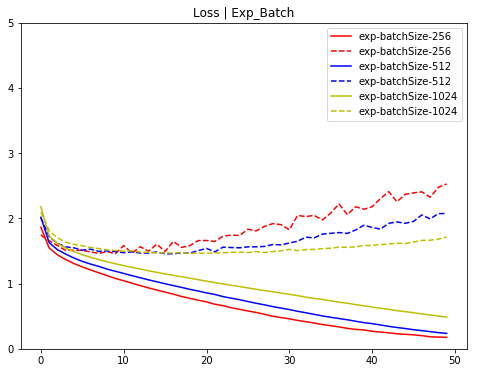

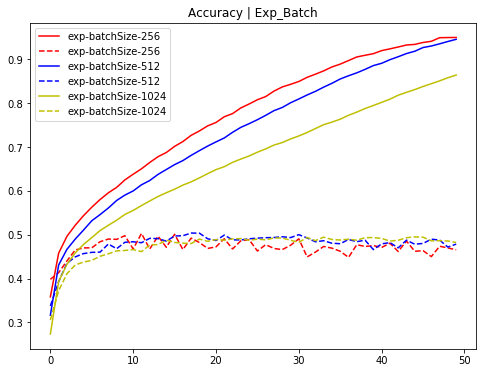

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
colors = ['r', 'b', 'y']

plt.figure(figsize=(8,6))
for i, tag in enumerate(results.keys()):
    plt.plot(range(len(results[tag]['train_loss'])), results[tag]['train_loss'], '-', label=tag, color=colors[i])
    plt.plot(range(len(results[tag]['valid_loss'])), results[tag]['valid_loss'], '--', label=tag, color=colors[i])
plt.legend()
plt.ylim([0, 5])
plt.title("Loss | Exp_Batch")
plt.show()

plt.figure(figsize=(8,6))
for i, tag in enumerate(results.keys()):
    plt.plot(range(len(results[tag]['train_acc'])), results[tag]['train_acc'], '-', label=tag, color=colors[i])
    plt.plot(range(len(results[tag]['valid_acc'])), results[tag]['valid_acc'], '--', label=tag, color=colors[i])
plt.legend()
plt.title("Accuracy | Exp_Batch")
plt.show()

In [0]:
results_2 = {}
for batch in BATCH_SIZE:
    model = build_mlp_2(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=batch,
              validation_data=(x_test, y_test), 
              shuffle=True)

    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = 'exp-batchSize-%s' % str(batch)
    results_2[exp_name_tag] = {
        'train_loss': train_loss,
        'valid_loss': valid_loss,
        'train_acc': train_acc,
        'valid_acc': valid_acc
    }
    

W0803 10:36:39.910468 139855625549696 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0803 10:36:39.944090 139855625549696 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0803 10:36:39.950594 139855625549696 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0803 10:36:40.062207 139855625549696 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0803 10:36:40.212718 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total para

W0803 10:36:40.431072 139855625549696 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 34s 676us/step - loss: 1.6944 - acc: 0.3984 - val_loss: 1.6064 - val_acc: 0.4223
Epoch 2/50
50000/50000 [==============================] - 34s 682us/step - loss: 1.4994 - acc: 0.4674 - val_loss: 1.5045 - val_acc: 0.4654
Epoch 3/50
50000/50000 [==============================] - 32s 645us/step - loss: 1.4288 - acc: 0.4908 - val_loss: 1.7302 - val_acc: 0.3975
Epoch 4/50
50000/50000 [==============================] - 32s 637us/step - loss: 1.3816 - acc: 0.5077 - val_loss: 1.4969 - val_acc: 0.4684
Epoch 5/50
50000/50000 [==============================] - 31s 625us/step - loss: 1.3403 - acc: 0.5229 - val_loss: 1.5580 - val_acc: 0.4485
Epoch 6/50
50000/50000 [==============================] - 33s 653us/step - loss: 1.3079 - acc: 0.5352 - val_loss: 1.6478 - val_acc: 0.4331
Epoch 7/50
50000/50000 [==============================] - 32s 649us/step - loss: 1.2781 - acc: 0.5462 - val_loss: 1.

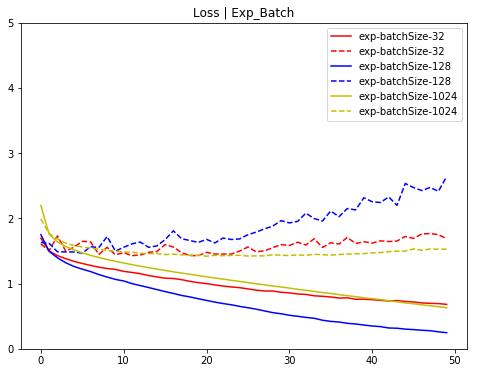

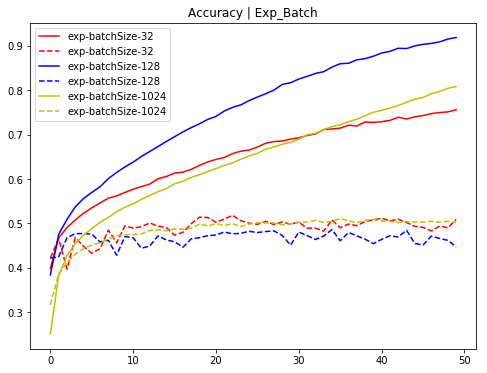

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
colors = ['r', 'b', 'y']

plt.figure(figsize=(8,6))
for i, tag in enumerate(results_2.keys()):
    plt.plot(range(len(results_2[tag]['train_loss'])), results_2[tag]['train_loss'], '-', label=tag, color=colors[i])
    plt.plot(range(len(results_2[tag]['valid_loss'])), results_2[tag]['valid_loss'], '--', label=tag, color=colors[i])
plt.legend()
plt.ylim([0, 5])
plt.title("Loss | Exp_Batch")
plt.show()

plt.figure(figsize=(8,6))
for i, tag in enumerate(results_2.keys()):
    plt.plot(range(len(results_2[tag]['train_acc'])), results_2[tag]['train_acc'], '-', label=tag, color=colors[i])
    plt.plot(range(len(results_2[tag]['valid_acc'])), results_2[tag]['valid_acc'], '--', label=tag, color=colors[i])
plt.legend()
plt.title("Accuracy | Exp_Batch")
plt.show()

In [7]:
results_2_1 = {}
for batch in BATCH_SIZE:
    model = build_mlp_2_1(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=batch,
              validation_data=(x_test, y_test), 
              shuffle=True)

    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = 'exp-batchSize-%s' % str(batch)
    results_2_1[exp_name_tag] = {
        'train_loss': train_loss,
        'valid_loss': valid_loss,
        'train_acc': train_acc,
        'valid_acc': valid_acc
    }
    

W0803 16:37:01.277849 139970958149504 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0803 16:37:01.774066 139970958149504 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0803 16:37:01.902592 139970958149504 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0803 16:37:01.931658 139970958149504 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0803 16:37:02.298422 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 3072)              12288     
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)               512       
__________

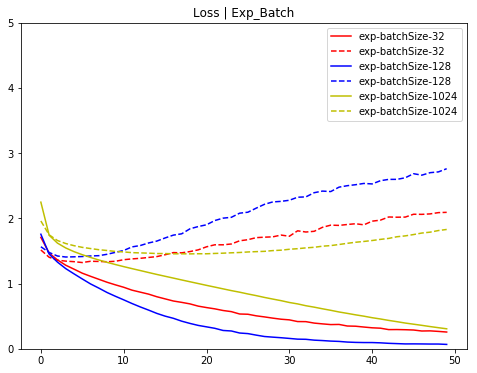

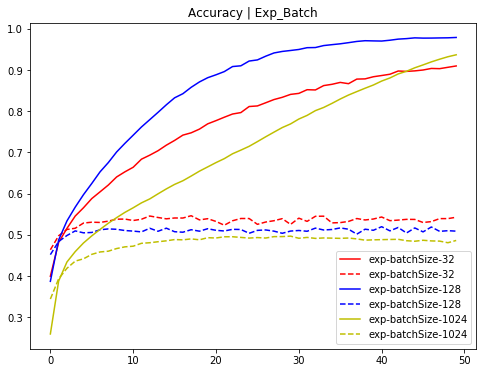

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
colors = ['r', 'b', 'y']

plt.figure(figsize=(8,6))
for i, tag in enumerate(results_2_1.keys()):
    plt.plot(range(len(results_2_1[tag]['train_loss'])), results_2_1[tag]['train_loss'], '-', label=tag, color=colors[i])
    plt.plot(range(len(results_2_1[tag]['valid_loss'])), results_2_1[tag]['valid_loss'], '--', label=tag, color=colors[i])
plt.legend()
plt.ylim([0, 5])
plt.title("Loss | Exp_Batch")
plt.show()

plt.figure(figsize=(8,6))
for i, tag in enumerate(results_2_1.keys()):
    plt.plot(range(len(results_2_1[tag]['train_acc'])), results_2_1[tag]['train_acc'], '-', label=tag, color=colors[i])
    plt.plot(range(len(results_2_1[tag]['valid_acc'])), results_2_1[tag]['valid_acc'], '--', label=tag, color=colors[i])
plt.legend()
plt.title("Accuracy | Exp_Batch")
plt.show()

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
colors = ['r', 'b', 'y']

plt.figure(figsize=(8,6))
for i, tag in enumerate(results_2_1.keys()):
    plt.plot(range(len(results_2_1[tag]['train_loss'])), results_2_1[tag]['train_loss'], '-', label=tag, color=colors[i])
    plt.plot(range(len(results_2_1[tag]['valid_loss'])), results_2_1[tag]['valid_loss'], '--', label=tag, color=colors[i])
plt.legend()
plt.ylim([0, 5])
plt.title("Loss | Exp_Batch")
plt.show()

plt.figure(figsize=(8,6))
for i, tag in enumerate(results_2_1.keys()):
    plt.plot(range(len(results_2_1[tag]['train_acc'])), results_2_1[tag]['train_acc'], '-', label=tag, color=colors[i])
    plt.plot(range(len(results_2_1[tag]['valid_acc'])), results_2_1[tag]['valid_acc'], '--', label=tag, color=colors[i])
plt.legend()
plt.title("Accuracy | Exp_Batch")
plt.show()